※　統計的機械学習ー生成モデルに基づくパターン認識ー（杉山将,2019）の第10章の内容に基づいて実装した

In [1]:
import random
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
%matplotlib inline

# モンテカルロ法：pi の近似計算

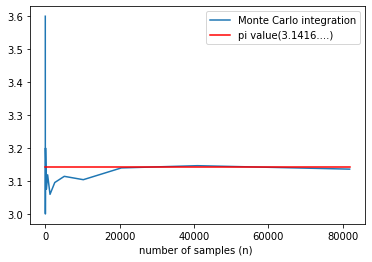

<Figure size 432x288 with 0 Axes>

In [2]:
def f(x,y):
    if (x*x+y*y<=1):
        return 1
    else:
        return 0

n = 10
N = []
P = []
while n <= 100000:
    s = np.random.uniform(-1,1,(n,2))
    nn = 0
    for x in s:
        nn+=f(x[0],x[1])
        
    pi = 4*nn/n
    N.append(n)
    P.append(pi)
    n = n*2

P_r = [np.pi]*len(N)
plt.plot(N,P)
plt.plot(N,P_r,c='red')
plt.legend(["Monte Carlo integration","pi value(3.1416....)"])
plt.xlabel("number of samples (n) ")
plt.show()
plt.savefig("pi_calculation.jpg")

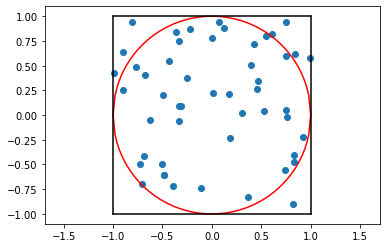

In [3]:
s_s = np.random.uniform(-1,1,(50,2))
xx = np.linspace(-1,1,100)
plt.plot(xx,np.sqrt(1-xx*xx),c="red")
plt.plot(xx,-np.sqrt(1-xx*xx),c="red")

plt.plot(xx,[1]*len(xx),c="black")
plt.plot(xx,[-1]*len(xx),c="black")
plt.plot([1]*len(xx),xx,c="black")
plt.plot([-1]*len(xx),xx,c="black")



plt.scatter(s_s[:,0],s_s[:,1])
plt.axis('equal')
plt.show()

# 重点サンプリング法：ラプラス分布の分散の近似計算

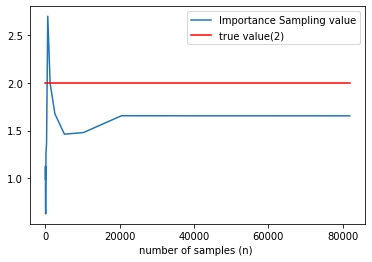

In [4]:
def f(x):
    return x*x
def p_pdf(x):
    return 0.5*np.exp(-abs(x))
def imp_pdf(x):
    return norm.pdf(x)

n = 10
N = []
P = []
while n <= 100000:
    s = np.random.normal(0,1,n)
    nn = 0
    for x in s:
        nn+=f(x)*p_pdf(x)/imp_pdf(x)
        
    p = nn/n
    N.append(n)
    P.append(p)
    n = n*2

P_r = [2]*len(N)
plt.plot(N,P)
plt.plot(N,P_r,c='red')
plt.legend(["Importance Sampling value","true value(2)"])
plt.xlabel("number of samples (n) ")
plt.show()

# 逆関数サンプリング法：ラプラス分布

In [5]:
def sgn(x):
    if x>0:
        return 1
    elif x==0:
        return 0
    else:
        return -1
    
def p_laplace(x):
    return 0.5*np.exp(-abs(x))

#def P_laplace_cum(x):
    #return 0.5*((1+sgn(x))(1-np.exp(-abs(x))))

def P_laplace_inv(u):
    k = 1-2*abs(u-0.5)
    return -1*sgn(u-0.5)*np.log(k)

def reverse_generator(X):
    res = []
    for u in X:
        res.append(P_laplace_inv(u))
    return res

### ラプラス分布に従う確率変数の生成（逆関数サンプリング法）

n_sample =  50


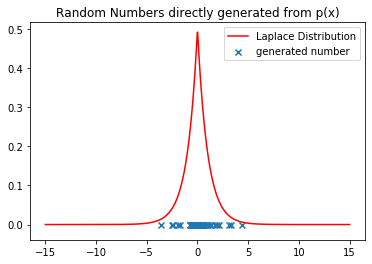

In [6]:
n_sample = 50
s = np.random.uniform(0,1,n_sample)
theta = reverse_generator(s)
   
print("n_sample = ",n_sample)
gen_xx =random.sample(theta,n_sample)
plt.scatter(gen_xx,[0]*n_sample,marker='x')
xx=np.linspace(-15,15,1000)
plt.plot(xx,[p_laplace(i) for i in xx],c='red')
plt.legend(['Laplace Distribution','generated number'])
plt.title("Random Numbers directly generated from p(x)")
plt.show()

### 生成された標本を用いたモンテカルロ積分の計算：ラプラス分布の分散

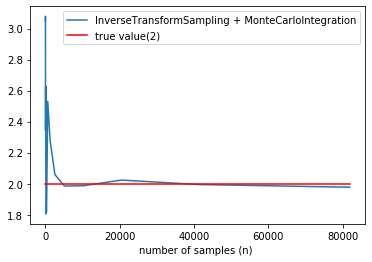

In [7]:
N = []
P = []
n= 10
while n <= 100000:
    s = np.random.uniform(0,1,n)
    theta = reverse_generator(s)
    p = 0
    for x in theta:
        p += x*x
    N.append(n)
    P.append(p/n)
    n = n*2
    
P_r = [2]*len(N)
plt.plot(N,P)
plt.plot(N,P_r,c='red')
plt.legend(["InverseTransformSampling + MonteCarloIntegration","true value(2)"])
plt.xlabel("number of samples (n) ")
plt.show()

# 棄却サンプリング法 （rejection sampling）

In [8]:
def p_laplace(x):
    return 0.5*np.exp(-abs(x))

def p_proxy(x):
    return norm.pdf(x)

def rejection_generator(n):
    L = 15
    random_samples = []
    while len(random_samples) < n:
        proposal = np.random.randn()
        v = np.random.uniform(0,L)
        if v <= (p_laplace(proposal)/p_proxy(proposal)):
            random_samples.append(proposal)
    return random_samples

generating...
n_sample =  50


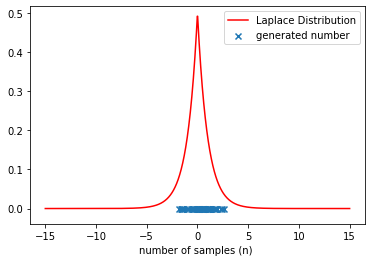

In [9]:
print("generating...")
random_samples = rejection_generator(n=50)
print("n_sample = ",len(random_samples))
plt.scatter(random_samples,[0]*len(random_samples),marker='x')
xx=np.linspace(-15,15,1000)
plt.plot(xx,[p_laplace(i) for i in xx],c='red')
plt.legend(["Laplace Distribution","generated number"])
plt.xlabel("number of samples (n) ")
plt.show()

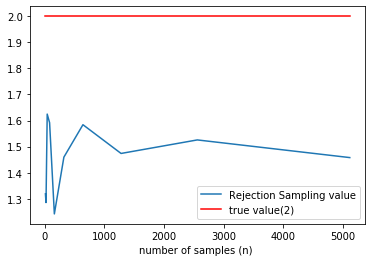

In [10]:
N = []
P = []
n= 10
while n <= 10000:
    theta = rejection_generator(n=n)
    p = 0
    for x in theta:
        p += x*x
    N.append(n)
    P.append(p/n)
    n = n*2
    
P_r = [2]*len(N)
plt.plot(N,P)
plt.plot(N,P_r,c='red')
plt.legend(["Rejection Sampling value","true value(2)"])
plt.xlabel("number of samples (n) ")
plt.show()

# マルコフ連鎖モンテカルロ法（MCMC method）

In [11]:
def p_laplace(x):
    return 0.5*np.exp(-abs(x))

def p_proxy(x,theta,sigma):
    return norm.pdf(x,theta,sigma)

def MCMC_generator(n):
    random_samples = []
    theta_i = 0
    while len(random_samples) < n:
        proposal = np.random.normal(loc=theta_i,scale=1)
        v = np.random.uniform(0,1)
        a = p_laplace(proposal)*p_proxy(theta_i,proposal,1)
        b = p_laplace(theta_i)*p_proxy(proposal,theta_i,1)
        if v <= (a/b):
            random_samples.append(proposal)
            theta_i = proposal
    return random_samples

n_sample =  50


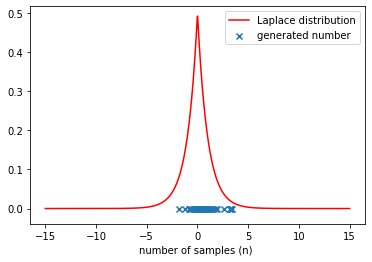

In [12]:
n = 50
random_samples = MCMC_generator(n)
print("n_sample = ",n)
plt.scatter(random_samples,[0]*n,marker='x')
xx=np.linspace(-15,15,1000)
plt.plot(xx,[p_laplace(i) for i in xx],c='red')
plt.legend(["Laplace distribution","generated number"])
plt.xlabel("number of samples (n) ")
plt.show()

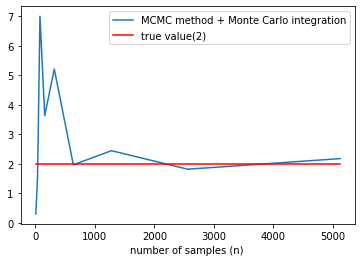

In [13]:
N = []
P = []
n= 10
while n <= 10000:
    theta = MCMC_generator(n=n)
    p = 0
    for x in theta:
        p += x*x
    N.append(n)
    P.append(p/n)
    n = n*2
    
P_r = [2]*len(N)
plt.plot(N,P)
plt.plot(N,P_r,c='red')
plt.legend(["MCMC method + Monte Carlo integration","true value(2)"])
plt.xlabel("number of samples (n) ")
plt.show()